# Case de Machine Learning para Live Class FIAP
# Agosto de 2022
## Instrutor: Bruno Curtarelli (Head of Data Science - Petlove & Co)

### Currículo
- Estatística Unicamp
- MBA gestão FIA/PROVAR
- Especializações em Machine Learning e Deep Learning - Andrew Ng (coursera)

### Experiência
- Data Scientist Nielsen
- Head Data Science Behup
- Head Data Science e fundador da área de dados da Petlove em 2018

Atualmente trabalhando com foco em Planejamento e Ressuprimento, desenvolvendo produtos de dados para previsão de demanda e sugestão de compra, além de robôs para monitorar todo o processo e auxiliar na melhoria contínua dos principais indicadores da companhia

Encontro do time de Digital da Petlove & Co

<img src="bruno.jpeg" alt=![bruno.jpeg] align="left" width="700" height="700" />

## Contexto do Problema que veremos hoje: e-commerce / varejista

### Dados disponíveis:
- Transações por cliente, com data, produto, valores

### O que gostaríamos de ter?
- Uma previsão para saber se o cliente vai recomprar e quanto ele deve gastar conosco futuramente
- Uma segmentação dos clientes por nível de gastos e engajamento na nossa loja

### Como usamos isso na prática?
- Otimizar investimentos de marketing
- Customizar campanhas de CRM
- Trabalhar descontos e brindes de maneira inteligente
- Ações de retenção e de atendimento personalizadas

### Pacotes utilizados

In [6]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

### Leitura dos dados
Obtidos em: https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis?select=Assignment-1_Data.csv

In [7]:
df = pd.read_csv('transaction_data_example.csv', low_memory=False)

### Descrição dos Dados

- transaction_id: código da transação
- product: descritivo do produto
- quantity: quantidade comprada
- date: timestamp com a data e hora da transação
- price: preço unitário do produto
- customer_id: código de identificação do cliente
- country: país de residência do cliente

In [8]:
df.head()

,transaction_id,product,quantity,date,price,customer_id,country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Com a função "describe" podemos ver a contagem dos campos numéricos e suas distribuições

In [9]:
df.describe()

,quantity,price,customer_id
count,522064.000000,522064.000000,388023.000000
mean,10.090435,3.826801,15316.931710
std,161.110525,41.900599,1721.846964
min,-9600.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13950.000000
50%,3.000000,2.080000,15265.000000
75%,10.000000,4.130000,16837.000000
max,80995.000000,13541.330000,18287.000000


### Com a função "info" podemos ver a tipagem das colunas

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  522064 non-null  object 
 1   product         520609 non-null  object 
 2   quantity        522064 non-null  int64  
 3   date            522064 non-null  object 
 4   price           522064 non-null  float64
 5   customer_id     388023 non-null  float64
 6   country         522064 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 27.9+ MB


## Limpeza de dados faltantes, ajuste de tipos e criação das demais variáveis

### Remoção de clientes e produtos faltantes

In [15]:
df_clean = df.loc[(df['customer_id'].notna()) & (df['product'].notna())].copy()

### Valor total de cada item-pedido
Quantidade x Preço

In [16]:
df_clean['total_value'] = df_clean['quantity']*df_clean['price']

### Ajustes nos tipos de datas e criação da data atual
Como os dados eram antigos, fiz um ajuste nas datas (+10 anos) apenas para trazer mais ao presente

In [17]:
df_clean['date'] = pd.to_datetime(df_clean['date'])+pd.offsets.DateOffset(years=10)
df_clean['current_date'] = pd.Timestamp.now()

# Análises Descritivas

### TOP 10 Países na base de dados - em número de clientes

### Função para agregação dos dados por países e criação de estatísticas

In [18]:
def country_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'customers': x['customer_id'].nunique()
        , 'total_sales': x['total_value'].sum()
        , 'average_ticket': x['total_value'].sum()/x['transaction_id'].nunique()
        , 'distinct_products': x['product'].nunique()
        , 'total_quantity': x['quantity'].sum()
        , 'average_products_per_transaction': x['product'].count()/x['transaction_id'].nunique()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['transactions'
                                  , 'customers'
                                  , 'total_sales'
                                  , 'average_ticket'
                                  , 'distinct_products'
                                  , 'total_quantity'
                                  , 'average_products_per_transaction'
                                  , 'average_quantity'
                                  ])

## Podemos notar que a maior parte das transações estão no Reino Unido
- Suiça é o pais com maior ticket médio e maior número de produtos por pedido
- Espanha e Italia são os países de menor ticket e produtos por pedido

In [19]:
top_countries = df_clean.groupby('country').apply(country_agg).sort_values('customers', ascending=False)
top_countries['customer_percent'] = top_countries['customers']/top_countries['customers'].sum()*100
top_countries.head(10)

,transactions,customers,total_sales,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,customer_percent
country,,,,,,,,,
United Kingdom,16649.0,3921.0,7308391.554,438.968800,3833.0,4269472.0,21.283260,256.440147,91.186047
Germany,457.0,94.0,228867.140,500.803370,1695.0,119263.0,19.785558,260.969365,2.186047
France,389.0,87.0,209024.050,537.336889,1543.0,111472.0,21.444730,286.560411,2.023256
Spain,90.0,30.0,61577.110,684.190111,1104.0,27951.0,27.611111,310.566667,0.697674
Belgium,98.0,25.0,41196.340,420.370816,784.0,23237.0,20.724490,237.112245,0.581395
Switzerland,51.0,21.0,56443.950,1106.744118,954.0,30083.0,36.117647,589.862745,0.488372
Portugal,57.0,19.0,33439.890,586.664737,693.0,16122.0,25.649123,282.842105,0.441860
Italy,38.0,14.0,17483.240,460.085263,476.0,8112.0,19.947368,213.473684,0.325581
Austria,17.0,11.0,10198.680,599.922353,306.0,4881.0,23.411765,287.117647,0.255814


## Análises de clientes

### Função para agregação dos dados por clientes e criação de estatísticas

In [20]:
def custom_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'countries': x['country'].nunique()
        , 'total_spent': x['total_value'].sum()
        , 'average_ticket': x['total_value'].sum()/x['transaction_id'].nunique()
        , 'distinct_products': x['product'].nunique()
        , 'total_quantity': x['quantity'].sum()
        , 'average_products_per_transaction': x['product'].count()/x['transaction_id'].nunique()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
        , 'recency': (x['current_date'].max() - x['date'].max())/np.timedelta64(1,'D')  
        , 'time': (x['date'].max() - x['date'].min())/np.timedelta64(1,'D')  
    }
    return pd.Series(names, index=['transactions'
                                  , 'countries'
                                  , 'total_spent'
                                  , 'average_ticket'
                                  , 'distinct_products'
                                  , 'total_quantity'
                                  , 'average_products_per_transaction'
                                  , 'average_quantity'
                                  , 'recency'
                                  , 'time'])

### Dataset com os indicadores agregados por clientes

In [21]:
customers = df_clean.groupby('customer_id').apply(custom_agg).reset_index()

### Criação do tempo médio entre pedidos
- No caso do cliente ter 1 pedido, colocamos 9999 (para penalizar essa variável)
- Do contrário, o tempo médio entre pedidos é o tempo entre o primeiro e o útimo pedido dividido pelo total de transações menos 1

In [22]:
customers['average_time_between_orders'] = np.where(customers['time']<0.001, 9999, customers['time']/(customers['transactions']-1))

In [23]:
customers.head()

,customer_id,transactions,countries,total_spent,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,recency,time,average_time_between_orders
0,12346.0,1.0,1.0,77183.60,77183.600000,1.0,74215.0,1.000,74215.000000,577.486218,0.000000,9999.000000
1,12347.0,7.0,1.0,4310.00,615.714286,103.0,2458.0,26.000,351.142857,254.242468,365.038194,60.839699
2,12349.0,1.0,1.0,1757.55,1757.550000,73.0,631.0,73.000,631.000000,270.493163,0.000000,9999.000000
3,12350.0,1.0,1.0,334.40,334.400000,17.0,197.0,17.000,197.000000,562.236218,0.000000,9999.000000
4,12352.0,8.0,1.0,2506.04,313.255000,59.0,536.0,10.625,67.000000,288.294551,260.086111,37.155159


### Somente 3 Clientes possuem compras em mais de 1 País

In [96]:
customers.loc[customers['countries']>1, 'customer_id'].nunique()

3

### Distribuição de clientes de acordo com a quantidade de transações
- A maioria dos clientes possuem poucas transações

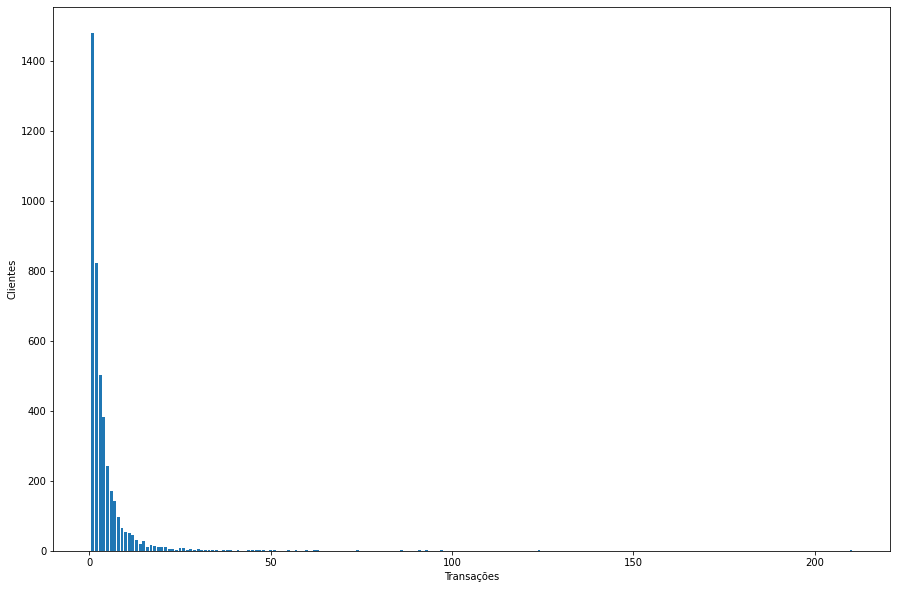

In [153]:
dist_transactions = customers.groupby('transactions').nunique()[['customer_id']].reset_index()
plt.figure(figsize=(15,10))
plt.bar(dist_transactions['transactions'], dist_transactions['customer_id'])
plt.xlabel('Transações')
plt.ylabel('Clientes')
plt.show()

### Fazendo um "zoom" na distribuição, cortando clientes com número de transações muito elevado

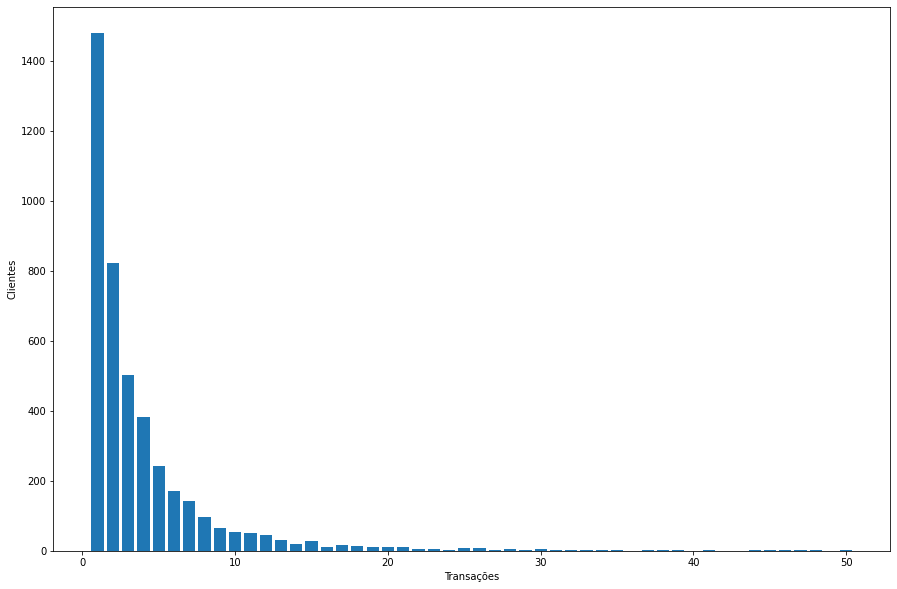

In [154]:
dist_transactions = customers.groupby('transactions').nunique()[['customer_id']].reset_index()
plt.figure(figsize=(15,10))
plt.bar(dist_transactions.loc[dist_transactions['transactions']<=50, 'transactions'], dist_transactions.loc[dist_transactions['transactions']<=50, 'customer_id'])
plt.xlabel('Transações')
plt.ylabel('Clientes')
plt.show()

### Criação de faixas mais agregadas

In [24]:
col = 'transactions'
conditions = [customers[col] == 1
              , (customers[col] > 1) & (customers[col] <= 5)
              , (customers[col] > 5) & (customers[col] <= 10)
              , customers[col] > 10]
choices = ['1. Unique Order'
           , '2. Between 2-5 Orders'
           , '3. Between 6-10 Orders' 
           , '4. More than 10 Orders' ]
    
customers['transaction_frequency'] = np.select(conditions, choices, default=np.nan)

In [42]:
def customers_agg(x):
    names = {
        'customers': x['customer_id'].nunique()
        , 'average_distinct_products': x['distinct_products'].sum()/x['transactions'].sum()
        , 'total_quantity': x['total_quantity'].sum()
        , 'average_quantity': x['total_quantity'].sum()/x['transactions'].sum()
        , 'total_spent': x['total_spent'].sum()
        , 'average_ticket': x['total_spent'].sum()/x['transactions'].sum()
        , 'average_time_between_orders': x['time'].sum()/(x['transactions'].sum()-x['customer_id'].nunique())
        , 'transactions_per_customer': x['transactions'].sum()/x['customer_id'].nunique()
        , 'average_recency': x['recency'].sum()/x['customer_id'].nunique()
    }
    return pd.Series(names, index=['customers'
                                  , 'average_distinct_products'
                                  , 'total_quantity'
                                  , 'average_quantity'
                                  , 'total_spent'
                                  , 'average_ticket'
                                  , 'average_time_between_orders'
                                  , 'transactions_per_customer'
                                  , 'average_recency'
                                  ])

### Alavancas de engajamento e valor:
- recency: recência ou quanto tempo faz desde a última compra
- transactions: número total de pedidos que o cliente já fez
- averag_ticket: gasto médio por pedido
- average_time_between_orders: frequência de compra ou tempo médio em dias, entre os pedidos

Clientes mais engajados, com mais pedidos e menor tempo entre pedidos também possuem maior ticket médio

In [43]:
customers.groupby('transaction_frequency').apply(customers_agg)

/tmp/ipykernel_11555/640007857.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  , 'average_time_between_orders': x['time'].sum()/(x['transactions'].sum()-x['customer_id'].nunique())


,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
transaction_frequency,,,,,,,,,
1. Unique Order,1481.0,21.657664,413018.0,278.877785,607958.561,410.505443,inf,1.000000,408.969138
2. Between 2-5 Orders,1952.0,18.615424,1352608.0,229.255593,2340022.773,396.614029,78.445839,3.022541,325.217201
3. Between 6-10 Orders,529.0,15.189954,899451.0,229.334778,1486894.540,379.116405,42.015255,7.413989,283.607470
4. More than 10 Orders,335.0,9.006706,2337370.0,340.724490,4129650.520,601.989872,16.796358,20.477612,267.947155


### Distribuição do Ticket Médio

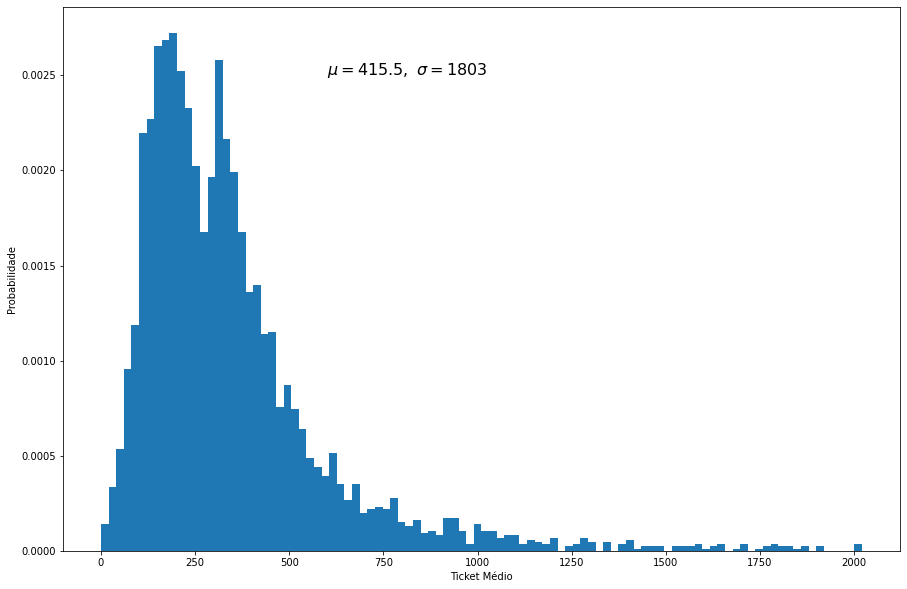

In [100]:
ol = customers.quantile(.99)['average_ticket']
media = round(customers[['average_ticket']].mean().values[0],1)
desvio = round(customers[['average_ticket']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['average_ticket']<=ol, 'average_ticket'], 100, density=True)
plt.xlabel('Ticket Médio')
plt.ylabel('Probabilidade')
plt.text(600, .0025, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

### Distribuição da Recência

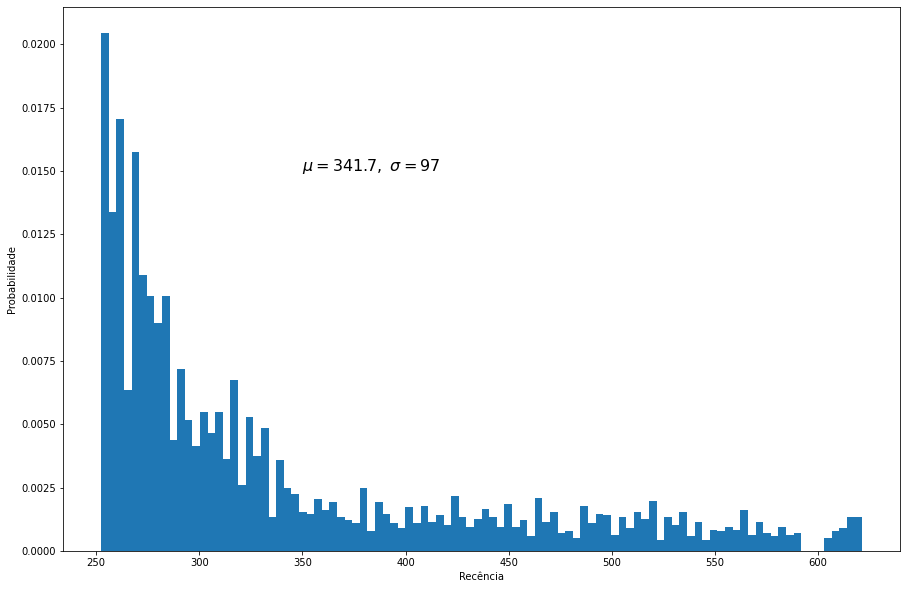

In [121]:
ol = customers.quantile(.99)['recency']
media = round(customers.loc[customers['recency']<=ol, ['recency']].mean().values[0],1)
desvio = round(customers.loc[customers['recency']<=ol, ['recency']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['recency']<=ol, 'recency'], 100, density=True)
plt.xlabel('Recência')
plt.ylabel('Probabilidade')
plt.text(350, .015, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

### Distribuição do tempo médio entre pedidos

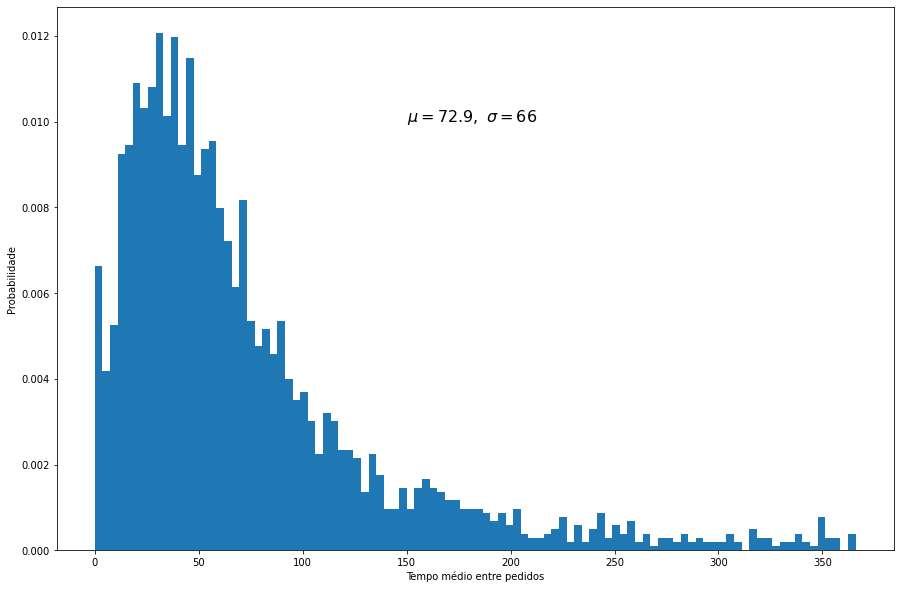

In [111]:
media = round(customers.loc[customers['average_time_between_orders']<9999, ['average_time_between_orders']].mean().values[0],1)
desvio = round(customers.loc[customers['average_time_between_orders']<9999, ['average_time_between_orders']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['average_time_between_orders']<9999, 'average_time_between_orders'], 100, density=True)
plt.xlabel('Tempo médio entre pedidos')
plt.ylabel('Probabilidade')
plt.text(150, .01, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

# Segmentação de Clientes usando RFV

## Recência, Frequência, Valor, +Quantidade de Pedidos

### Técnicas utilizadas:
**K-Means Clustering:** Método de aprendizado não supervisionado
O método de clusterização K Means busca alocar as amostras em grupos (clusters) mais homogêneos possíveis e heterogêneos entre si.
Ele funciona assim:
- Primeiro é feita a definição do número de clusters que queremos segmentar nossos dados
- Depois são defindos os centróides (podem ser pontos aleatórios no espaço dos dados, ou pontos de amostras aleatórias, ou pontos pré-definidos). Os centróides são os pontos de referência com os quais vamos calcular as distâncias de cada amostra até eles
- As amostras são associadas aos centróides mais próximos e novos centróides são definidos com base nas amostras que ficaram num mesmo grupo
- O algoritmo vai iterando até que nenhuma amostra seja realocada, ou até um número pré-definido de iterações

fonte: https://www.nickmccullum.com/images/python-machine-learning/introduction-k-means-clustering/k-means-iteration.gif
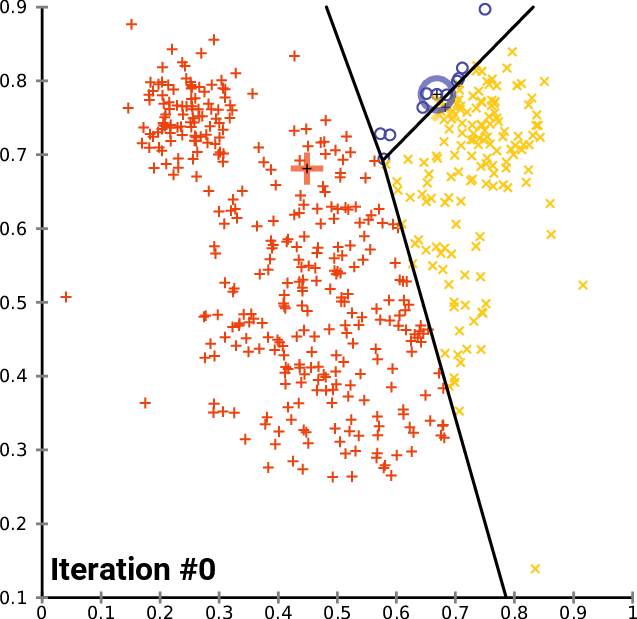

### Vamos usar o módulo scikit-learn para aplicar este algoritmo
https://scikit-learn.org/stable/

In [45]:
from sklearn.cluster import KMeans

### Primeiramente vamos aplicar o "método do cotovelo" para determinar o número de clusters para cada variável

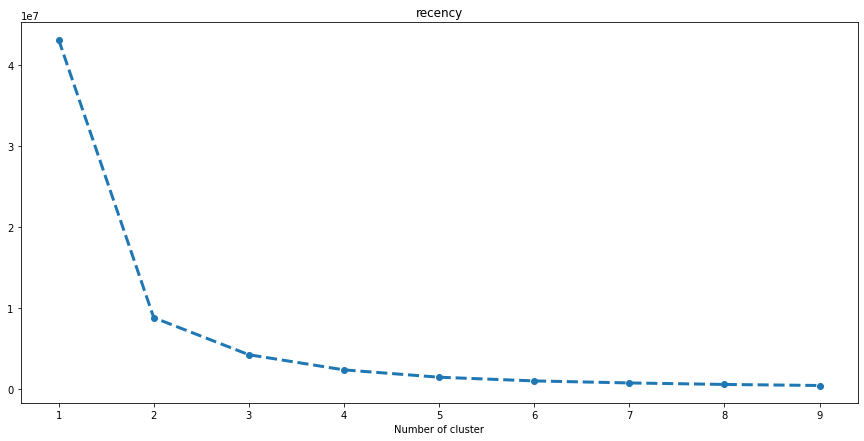

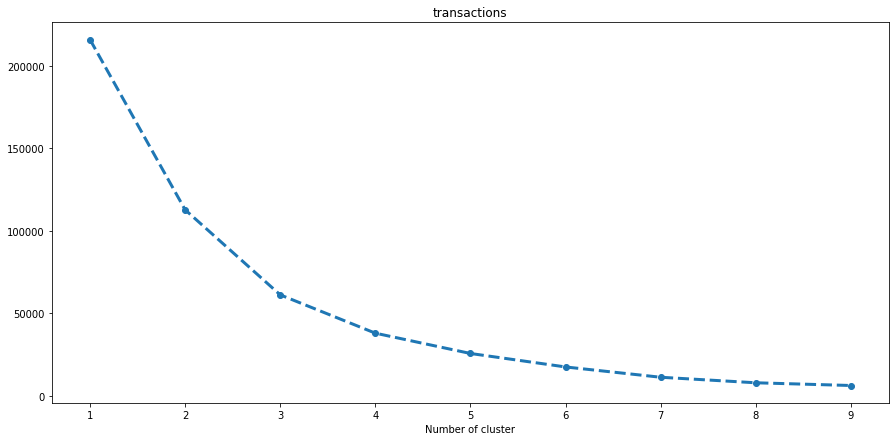

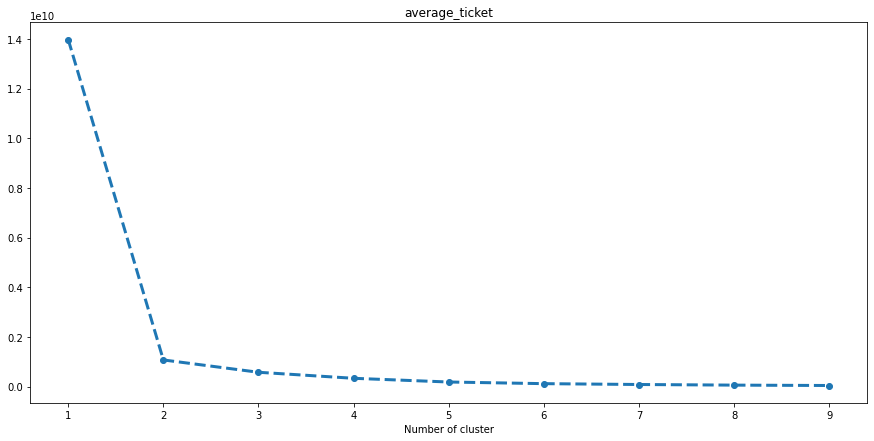

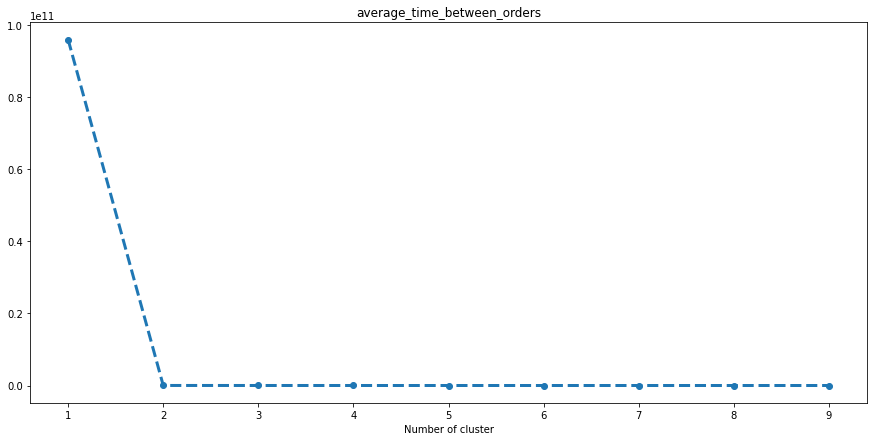

In [52]:
for cols in ['recency', 'transactions', 'average_ticket', 'average_time_between_orders']:
    sse={}
    clus = customers[[cols]].copy()
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(clus)
        clus["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure(figsize=(15,7))
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=3,linestyle='--', marker='o')
    plt.xlabel("Number of cluster")
    plt.title(cols)
    plt.show()

### Criando uma função para ordernar o número dos clusters de acordo com o sentido de cada variável
Exemplos:
- ticket médio, quanto maior melhor, então os clientes de maior ticket ficam no cluster de maior número e os de menor ticket ficam no grupo zero
- tempo entre pedidos, quanto menor melhor, então os clientes com maior tempo médio ficam no grupo zero e o de menor tempo ficam no grupo de maior número

In [53]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

### Dicionários com número de clusters por variável e sentido para ordenação

In [55]:
dict_clusters = {'recency':3, 'transactions':4, 'average_ticket':2, 'average_time_between_orders':2}
dict_sort = {'recency':False, 'transactions':True, 'average_ticket':True, 'average_time_between_orders':False}

### Aplicando o K-Means em cada variável

In [63]:
for m in dict_clusters.keys():
    kmeans = KMeans(n_clusters=dict_clusters[m])
    kmeans.fit(customers[[m]])

    customers[m+'_cluster'] = kmeans.predict(customers[[m]])
    
    customers = order_cluster(m+'_cluster', m, customers, dict_sort[m])

### Criando o score geral de cada cliente

In [60]:
customers['OverallScore'] = customers['recency_cluster'] + \
                              customers['transactions_cluster'] + \
                              customers['average_ticket_cluster'] +\
                              customers['average_time_between_orders_cluster']

### Base com todas variáveis por cliente, classificação de cluster de cada variável e scoragem final

In [61]:
customers

,customer_id,transactions,countries,total_spent,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,recency,time,average_time_between_orders,transaction_frequency,recency_cluster,transactions_cluster,average_ticket_cluster,average_time_between_orders_cluster,OverallScore
0,12346.0,1.0,1.0,77183.60,77183.600000,1.0,74215.0,1.000000,74215.000000,577.486218,0.000000,9999.000000,1. Unique Order,0,0,1,0,1
1,12350.0,1.0,1.0,334.40,334.400000,17.0,197.0,17.000000,197.000000,562.236218,0.000000,9999.000000,1. Unique Order,0,0,0,0,0
2,12354.0,1.0,1.0,1079.40,1079.400000,58.0,530.0,58.000000,530.000000,484.354274,0.000000,9999.000000,1. Unique Order,0,0,0,0,0
3,12361.0,1.0,1.0,189.90,189.900000,10.0,91.0,10.000000,91.000000,539.326496,0.000000,9999.000000,1. Unique Order,0,0,0,0,0
4,12370.0,1.0,1.0,277.20,277.200000,8.0,51.0,8.000000,51.000000,609.502190,0.000000,9999.000000,1. Unique Order,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,12971.0,86.0,1.0,11189.91,130.115233,96.0,9289.0,3.546512,108.011628,255.389690,368.818056,4.339036,4. More than 10 Orders,2,3,0,1,6
4293,13089.0,97.0,1.0,58825.83,606.451856,662.0,31070.0,18.742268,320.309278,254.527190,366.940972,3.822302,4. More than 10 Orders,2,3,0,1,6
4294,14606.0,93.0,1.0,12156.65,130.716667,825.0,6224.0,29.032258,66.924731,253.092468,372.104861,4.044618,4. More than 10 Orders,2,3,0,1,6
4295,15311.0,91.0,1.0,60767.90,667.779121,576.0,38194.0,26.142857,419.714286,252.403579,373.096528,4.145517,4. More than 10 Orders,2,3,0,1,6


### Resumo da base de clientes, agregando por Score Geral

In [62]:
customers.groupby('OverallScore').apply(customers_agg)

,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
OverallScore,,,,,,,,,
0,501.0,18.815476,83234.0,165.146825,153057.720,303.685952,0.000926,1.005988,550.071331
1,462.0,17.146032,219111.0,347.795238,332773.370,528.211698,37.117212,1.363636,442.096662
2,1093.0,18.202041,441329.0,225.167857,718595.072,366.630139,65.770925,1.793230,339.572613
3,1568.0,18.675226,1249746.0,225.993852,2065211.352,373.455941,73.539239,3.526786,285.788914
4,597.0,13.131465,1728469.0,267.647724,3024575.220,468.345497,30.751894,10.817420,270.789333
5,70.0,5.862605,1146962.0,481.916807,2052662.070,862.463055,10.724648,34.000000,257.302984
6,6.0,7.526391,133596.0,190.579173,217651.590,310.487290,3.202639,116.833333,253.533556


# Agora é mostrar os resultados para os times de Marketing, CRM, Atendimento e discutir as ações!

### Para que clientes poderíamos fazer campanhas de reativação?
### Quais clientes quero nutrir e engajar com melhores brindes?
### Quanto estamos dispostos a gastar para reter um cliente super engajado e valoroso?

## Uma abordagem alternativa:
### Segmentar usando todas as variáveis conjuntamente

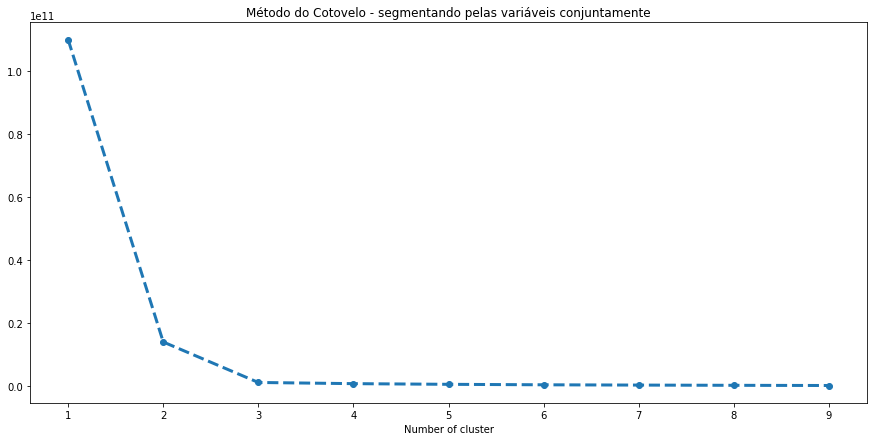

In [112]:
base_cluster = customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']].copy()
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster)
    base_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(15,7))
plt.plot(list(sse.keys()), list(sse.values()), linewidth=3,linestyle='--', marker='o')
plt.xlabel("Number of cluster")
plt.title("Método do Cotovelo - segmentando pelas variáveis conjuntamente")
plt.show()

### Aplicando o K-Means para as 4 variáveis juntas, segmentando em 3 grupos

In [119]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']])
customers['cluster_variaveis_conjuntas'] = kmeans.predict(customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']])

### Resultado dos clusters agregados

In [120]:
customers.groupby('cluster_variaveis_conjuntas').apply(customers_agg)

,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
cluster_variaveis_conjuntas,,,,,,,,,
0,2804.0,13.851663,4504476.0,270.409173,7780642.693,467.081444,40.540869,5.940799,310.19513
1,1491.0,21.652463,342759.0,228.201731,538227.601,358.340613,0.000568,1.007378,408.90729
2,2.0,1.333333,155212.0,51737.333333,245656.100,81885.366667,204.974306,1.500000,415.00219


# Explorando o módulo Lifetimes

### O lifetimes é uma biblioteca que permite medir clientes de maneira mais simplificada, pois ela já possui as funções para estimar a probabilidade de um cliente estar "vivo" (voltar a comprar) e quanto esse cliente deve gastar num horizonte de tempo futuro

A documentação completa desta biblioteca pode ser encontrada aqui:
https://lifetimes.readthedocs.io/en/latest/index.html

E a documentação do módulo no pip está aqui:
https://pypi.org/project/Lifetimes/

Para usar o Lifetimes precisamos fazer algumas pequenas adaptações nas variáveis que vamos usar.

- frequencia = número de recompras (total de pedidos menos 1)
- t = idade do cliente (tempo entre o primeiro pedido e a data de hoje)
- recencia = tempo entre primeiro e o último pedido (clientes com 1 pedido tem zero de recência)
- valor monetario = gasto médio do cliente

In [130]:
def lifetimes_agg(x):
    names = {
        'frequency': x['transaction_id'].nunique()-1
        , 't': (x['current_date'].max() - x['date'].min())/np.timedelta64(1,'D') 
        , 'recency': (x['date'].max() - x['date'].min())/np.timedelta64(1,'D') 
        , 'monetary_value': x['total_value'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['frequency'
                                  , 't'
                                  , 'recency'
                                  , 'monetary_value'
                                  ])

### Dataset com os indicadores agregados por clientes

In [131]:
data = df_clean.groupby('customer_id').apply(lifetimes_agg).reset_index()

In [132]:
data.head()

,customer_id,frequency,t,recency,monetary_value
0,12346.0,0.0,577.486218,0.000000,77183.600000
1,12347.0,6.0,619.280663,365.038194,615.714286
2,12349.0,0.0,270.493163,0.000000,1757.550000
3,12350.0,0.0,562.236218,0.000000,334.400000
4,12352.0,7.0,548.380663,260.086111,313.255000


In [135]:
data[(data['recency']!=0) & (data['frequency']==0)]

,customer_id,frequency,t,recency,monetary_value
2688,16063.0,0.0,512.282051,0.000694,335.32
2844,16272.0,0.0,368.450107,0.000694,411.70


In [136]:
data['recency'] = np.where(data['recency']<0.001, 0, data['recency'])

In [126]:
from lifetimes import BetaGeoFitter

In [137]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['t'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4297 subjects, a: 3.80, alpha: 24.48, b: 14.95, r: 0.38>


In [139]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.383580,0.010424,0.363149,0.404011
alpha,24.478237,1.042634,22.434675,26.521799
a,3.798298,0.393217,3.027593,4.569002
b,14.946430,1.899253,11.223893,18.668966


### Quanto maior a recência (tempo entre primeiro e último pedido) e quanto maior a quantidade a frequência (pedidos realizados), maior a probabilidade de recompra

In [173]:
from lifetimes.plotting import plot_frequency_recency_matrix
                            , plot_probability_alive_matrix
                            , plot_period_transactions
                            , plot_history_alive

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

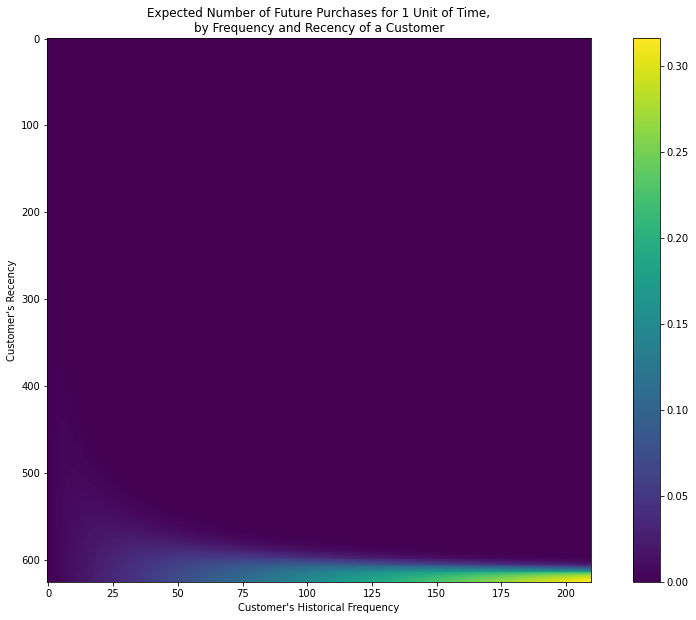

In [144]:
plt.figure(figsize=(15,10))
plot_frequency_recency_matrix(bgf)

### Probabilidade de um Cliente estar vivo

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

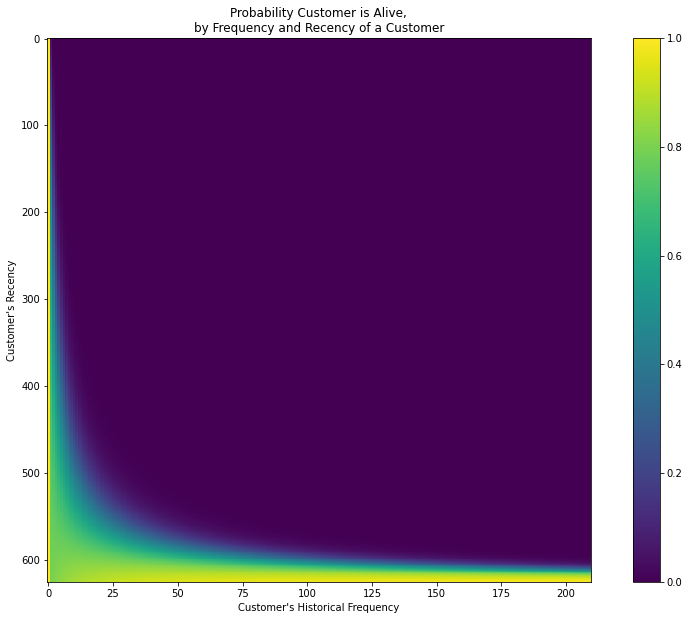

In [147]:
plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)

### Probabilidade de recompra daqui a 90 dias

In [151]:
t = 90
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['t'])
data.sort_values(by='predicted_purchases').tail(5)

,customer_id,frequency,t,recency,monetary_value,predicted_purchases
3294,16891.0,4.0,623.420940,369.986111,161.9400,0.200138
1405,14293.0,3.0,620.474413,365.207639,261.6400,0.200737
4002,17884.0,3.0,623.395940,367.973611,179.3625,0.200832
3037,16539.0,3.0,625.250801,370.709028,347.2025,0.201812
531,13077.0,3.0,618.279274,365.184028,182.3175,0.202649


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 1080x720 with 0 Axes>

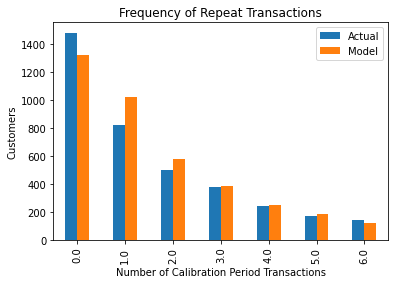

In [153]:
plt.figure(figsize=(15,10))
plot_period_transactions(bgf)

### Usando os dados transacionais para prever clientes individualmente

In [161]:
transaction_data = df_clean.groupby(['customer_id', 'date']).count().reset_index()
transaction_data = transaction_data[['customer_id', 'date']]

In [169]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(transaction_data, 'customer_id', 'date', observation_period_end=transaction_data[['date']].max().values[0])

bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4297 subjects, a: 0.00, alpha: 70.57, b: 7.36, r: 0.84>

In [215]:
summary[summary['frequency']<50].sort_values('frequency', ascending=False).head()

,frequency,recency,T
customer_id,,,
16422.0,47.0,352.0,369.0
14646.0,44.0,353.0,354.0
15039.0,41.0,359.0,368.0
13408.0,40.0,372.0,373.0
16029.0,38.0,335.0,373.0


In [216]:
t = 60
id = 13408.0

individual = summary.loc[summary.index.get_level_values(0) == id]

bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

customer_id
13408.0    5.522953
dtype: float64

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

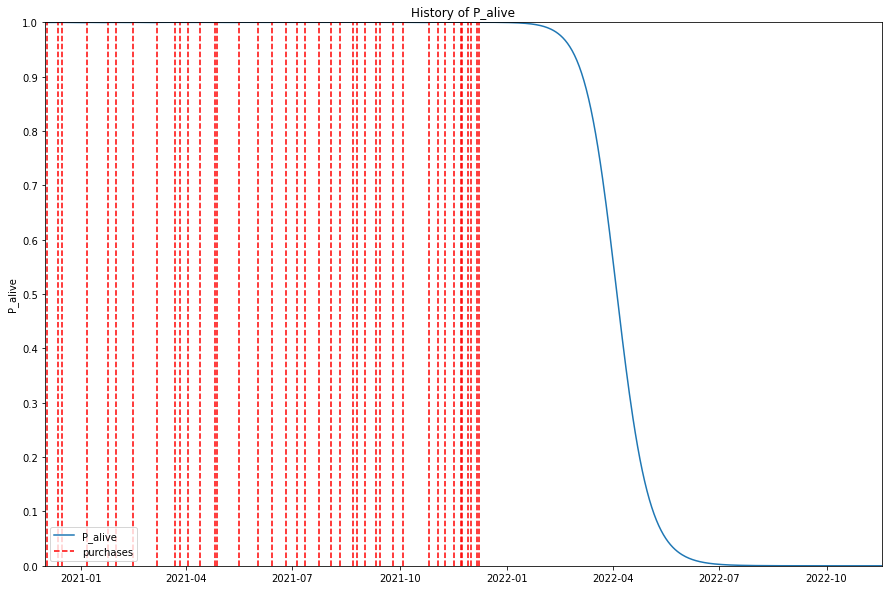

In [217]:
sp_trans = transaction_data.loc[transaction_data['customer_id'] == id]
days_since_birth = round((pd.Timestamp.now()-sp_trans.min()[1])/np.timedelta64(1,'D'))+90
plt.figure(figsize=(15,10))
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')